# Lecture : Graph Convolutional Networks

## Lab 03 : GAT -- Exercise

### Xavier Bresson, Nian Liu

Velickovic, Cucurull, Casanova, Romero, Lio, Bengio, Graph Attention Networks, 2017      
https://arxiv.org/pdf/1710.10903


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/08_Graph_Convnets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [2]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time


# Visualize the artifical graph dataset used in this notebook

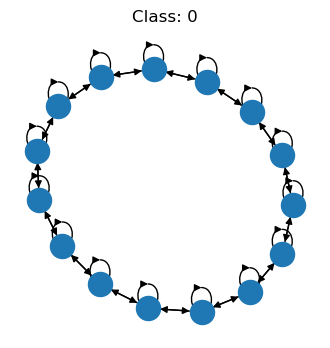

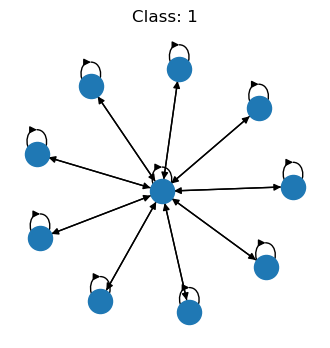

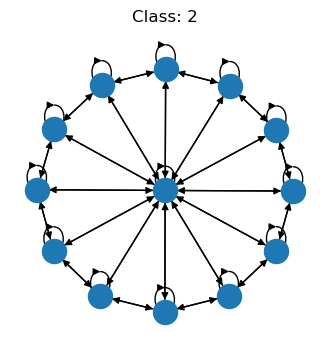

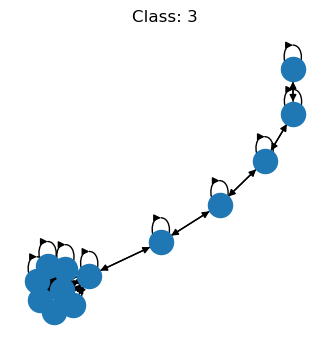

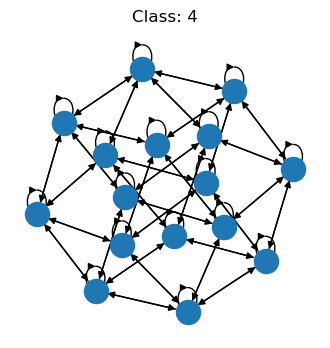

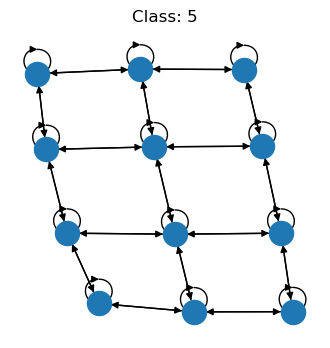

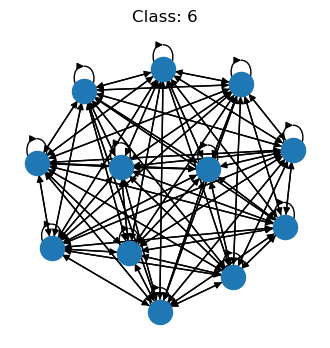

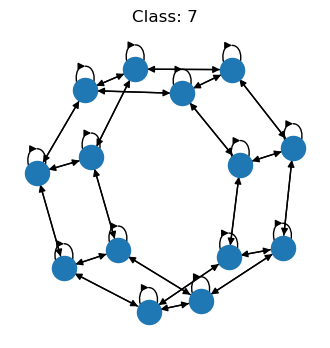

In [3]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c] 
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Generate train, val and test datasets 

## Add node feature

In [4]:
# Add node features to graphs
def add_node_features(dataset):
    for (graph,_) in dataset:
        # node feature = node in-degree
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float() # node feat is in-degree
    return dataset

# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_features(trainset)
testset = add_node_features(testset)
valset = add_node_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


# Define the collate function to prepare a batch of DGL graphs and test it

In [5]:
# collate function prepares a batch of graphs and labels 
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples)) # "graphs" is a list of "batch_size" DGL graphs
                                              # "labels" is a list of "batch_size" class labels
    # Create the DGL batch of graphs, which is equivalent to build a block diagonal matrix with all graphs in the batch
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels
    return batch_graphs, batch_labels

# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())


Graph(num_nodes=134, num_edges=990,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
tensor([3, 4, 5, 5, 7, 5, 0, 3, 6, 4])
batch_x: torch.Size([134, 1])


## Question 1: Design the class of GAT networks with DGL

Update equations:  
\begin{eqnarray}
h_{i}^{\ell+1} &=  \text{Concat}_{k=1}^{K} \Big( \text{ELU} \Big( \sum_{j \in \mathcal{N}_i} e_{ij}^{k,\ell}  \ W_1^{k,\ell} \ h_{j}^{\ell} \Big) \Big)\\
e_{ij}^{k,\ell} &=\textrm{Softmax}_{\mathcal{N}_i}(\hat e_{ij}^{k,\ell})= \frac{\exp(\hat e_{ij}^{k,\ell})}{\sum_{j' \in \mathcal{N}_i} \exp(\hat e_{ij'}^{k,\ell}) } \\
\hat e_{ij}^{k,\ell} &= \text{LeakyReLU} \Big( W_2^{k,\ell} \ \text{Concat} \big(   W_1^{k,\ell}h_{i}^{\ell} , \   W_1^{k,\ell}h_{j}^{\ell} \big) \ \Big) 
\end{eqnarray}

Instructions:

Step 1: Define an attention head layer
- Pass node feature and edge features along edges (src/j => dst/i) in `message_func()`.
- Calculate the unnormalized attentions between srd and des nodes $\hat e_{ij}^{k,\ell}$.
- Use `reduce_func()` to collect all messages={eij, Whj} sent to node dst/i with Step 1.
- Normalize attentions within neighbors, and sum over `Whj` weighted by normalized attentions $e_{ij}^{k,\ell}$.

Step 2: Define a multiple attention head layer
- Use Step 1 multiple times to get the multi-head attention in GAT.
- Each head is expected to capture a distinct similarity property between nodes.


In [6]:
# MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y


class GAT_one_head(nn.Module):  
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.W = nn.Linear(input_dim, output_dim, bias=True)
        self.a = nn.Linear(2*output_dim, 1, bias=False)
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        ########################################
        # YOUR CODE STARTS
        # Step 1: Calculate unnormalized attention between i and j as edge feature of `eij`, store `eij` as well as `Whj` for `reduce_func`
        ########################################
        Whi = edges.src['Wh']
        Whj = edges.dst['Wh']
        WhiWhj = torch.cat([Whi,Whj], dim=1)
        aWhiWhj = self.a(WhiWhj)
        eij = nn.LeakyReLU()(aWhiWhj)
        ########################################
        # YOUR CODE ENDS
        ########################################
        return {'eij' : eij, 'Whj' : Whj} # send message={Bhj, eij} to node dst/i

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={Whj} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        ########################################
        # YOUR CODE STARTS
        # Step 2: Normalize `eij`, and weight `Whj` to get updated features for src nodes `h`
        ########################################
        eij = nodes.mailbox['eij']
        eij = eij / torch.sum(eij)
        Whj = nodes.mailbox['Whj']
        Whj = Whj / torch.sum(Whj)
        exp_eij = torch.exp(eij)
        h = torch.sum(exp_eij * Whj, dim = 1)   # hi = Ahi + sum_j eta_ij * Bhj 
        ########################################
        # YOUR CODE ENDS
        ########################################
        return {'h' : h} # return update node feature hi
    
    def forward(self, g, h):
        g.ndata['Wh'] = self.W(h) # linear transformation 
        g.update_all(self.message_func,self.reduce_func) # update the node feature with DGL
        h = g.ndata['h'] # collect the node output of graph convolution
        h = nn.ELU()(h) # non-linear activation
        return h


class GAT_layer(nn.Module):
    
    def __init__(self, input_dim, num_heads, output_dim):
        super().__init__()
        self.GAT_one_heads = nn.ModuleList( [GAT_one_head(input_dim, output_dim) for _ in range(num_heads)] )
        
    def forward(self, g, h):
        h_in = h # residual connection
        list_h = []
        ########################################
        # YOUR CODE STARTS
        # Step 3: Concatenate results from each head, then give the multi-head attention based output
        ########################################
        for head in self.GAT_one_heads:
            h = head(g, h_in)
            list_h.append(h)
        h = torch.cat(list_h, dim = 1)
        ########################################
        # YOUR CODE ENDS
        ########################################
        # print('h',h.size())
        return h
    

class GAT_net(nn.Module):
    
    def __init__(self, net_parameters):
        super().__init__()
        input_dim = net_parameters['input_dim']
        num_heads = net_parameters['num_heads']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.GAT_layers = nn.ModuleList([ GAT_layer(hidden_dim, num_heads, hidden_dim//num_heads) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # graph convnet layers
        for GATlayer in self.GAT_layers:
            h = GATlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update


# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['num_heads'] = 4
net_parameters['hidden_dim'] = net_parameters['num_heads'] * 32
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GAT_net(net_parameters)
print(net)

def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
display_num_param(net)

train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
batch_x = batch_graphs.ndata['feat']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x)



GAT_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (GAT_layers): ModuleList(
    (0-3): 4 x GAT_layer(
      (GAT_one_heads): ModuleList(
        (0-3): 4 x GAT_one_head(
          (W): Linear(in_features=128, out_features=32, bias=True)
          (a): Linear(in_features=64, out_features=1, bias=False)
        )
      )
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=8, bias=True)
    )
  )
)
Number of parameters: 101384 (0.10 million)


# Train the network

In [7]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train()
    else:
        net.eval()
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = net.loss(batch_scores, batch_labels)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['num_heads'] = 4
net_parameters['hidden_dim'] = net_parameters['num_heads'] * 32
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GAT_net(net_parameters)
display_num_param(net)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, True)
    with torch.no_grad(): 
        epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, False)
        epoch_val_loss, epoch_val_acc = run_one_epoch(net, val_loader, False)  
    if not epoch%2:
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

Number of parameters: 101384 (0.10 million)
Epoch 0, time 38.1278, train_loss: 2.0804, test_loss: 2.0798, val_loss: 2.0798
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 2, time 38.0443, train_loss: 2.0766, test_loss: 2.0795, val_loss: 2.0795
                      train_acc: 0.1200, test_acc: 0.1100, val_acc: 0.1100
Epoch 4, time 37.1710, train_loss: 2.0797, test_loss: 2.0797, val_loss: 2.0797
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 6, time 36.2379, train_loss: 2.0794, test_loss: 2.0794, val_loss: 2.0794
                      train_acc: 0.1200, test_acc: 0.1200, val_acc: 0.1200
Epoch 8, time 38.2155, train_loss: 2.0785, test_loss: 2.0792, val_loss: 2.0792
                      train_acc: 0.1171, test_acc: 0.1200, val_acc: 0.1200
Epoch 10, time 37.6887, train_loss: 2.0800, test_loss: 2.0793, val_loss: 2.0793
                      train_acc: 0.1143, test_acc: 0.1200, val_acc: 0.1200
Epoch 12, time 37.2370, train_l